In [32]:
def round_frame(frame:int,events_array:pd.DataFrame,up_down:str)->int:
    """This function will round start, end frame to nearest bin in events """
    col_arr = events_array.columns.to_numpy()
    if up_down == 'up':
        bin_frame = col_arr[col_arr > frame].min()
    elif up_down == 'down':
        bin_frame = col_arr[col_arr < frame].max()
    return bin_frame

In [196]:
def get_overlapping_cells(container_id):
    
    # Load in experiment container data 
    desired_container_id = container_id
    desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
    desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first
    
    # Create a list of three arrays that contains cell IDs for each session
    cells_in_each_session = []
    i=0
    for session in desired_container:
        session_id = session["id"]
        session_data = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)
        specimen_ids = session_data.get_cell_specimen_ids()
        cells_in_each_session.append(specimen_ids)
        i+=1
        
    # isolate the cell IDs for only the overlapping sessions
    cells1 = list(cells_in_each_session[0])
    cells2 = list(cells_in_each_session[1])
    cells3 = list(cells_in_each_session[2])
    overlapping_cell_ids = [cell for cell in cells1 if cell in cells2 and cell in cells3]
    
    return overlapping_cell_ids

In [3]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import platform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
from event_utils import get_events
from create_stim_table import create_stim_df
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# This patch of code just ensures we get an easy to read font size for the duration of the notebook
import matplotlib
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [4]:
# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')
# Create data cache object 
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [8]:
desired_container_id = 688678764
desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first

# Get session IDs for each session
session_id = desired_container[2]["id"]

# load in session data 
session = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

In [16]:
# Get all event traces for all neurons in given session 
all_events = get_events(boc, session_id, "VISp", 30)

# Get full stimulus table for a given session
stim_df = create_stim_df(boc, session_id)

In [177]:
movie_df = stim_df[stim_df['stim_category']=="natural_movie_one"]
bin_size = all_events.columns.to_list()[1]
num_movie_chunks = int(len(movie_df)/bin_size)
mean_response_mtx = np.zeros((num_movie_chunks,len(overlapping_cells)))

In [97]:
overlapping_cells = get_overlapping_cells(688678764)

In [192]:
overlapping_cell_events = all_events.loc[overlapping_cells]

In [178]:
overlapping_cell_events = all_events.loc[overlapping_cells]

for i in range(num_movie_chunks):
    chunk_df = movie_df.iloc[0 + (bin_size*i):(bin_size+(bin_size*i))]
    start,end = chunk_df.start.to_list()[0],chunk_df.end.to_list()[-1]
    try:
        response = np.mean(overlapping_cell_events.loc[:,np.arange(round_frame(start,overlapping_cell_events,'down'),round_frame(end,overlapping_cell_events,'up')+bin_size, bin_size)],axis=1)
        mean_response_mtx[i,:] = response
    except Exception as e:
        print(e)

In [209]:
def get_response_matrix_movies(session_id, container_id, bin_size):
    # Get all event traces for overlapping neurons across sessions 
    all_events = get_events(boc, session_id, "VISp", bin_size)
    overlapping_cells = get_overlapping_cells(container_id)
    overlapping_cell_events = all_events.loc[overlapping_cells]

    # Get full stimulus table for a given session
    stim_df = create_stim_df(boc, session_id)

    movie_df = stim_df[stim_df['stim_category']=="natural_movie_one"]
    bin_size = all_events.columns.to_list()[1]
    num_movie_chunks = int(len(movie_df)/bin_size)
    mean_response_mtx = np.zeros((num_movie_chunks,len(overlapping_cells)))

    for i in range(num_movie_chunks):
        chunk_df = movie_df.iloc[0 + (bin_size*i):(bin_size+(bin_size*i))]
        start,end = chunk_df.start.to_list()[0],chunk_df.end.to_list()[-1]
        try:
            response = np.mean(overlapping_cell_events.loc[:,np.arange(round_frame(start,overlapping_cell_events,'down'),round_frame(end,overlapping_cell_events,'up')+bin_size, bin_size)],axis=1)
            mean_response_mtx[i,:] = response
        except Exception as e:
            print(e)
    
    return mean_response_mtx

In [210]:
def get_all_relevant_tables_movies(container_id, bin_size):

    # Select the relevant data for chosen container ID
    desired_container_id = container_id
    desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
    desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first
    
    # Get full response matrix for each presentation on each day 
    response_matrix1 = get_response_matrix_movies(desired_container[0]["id"], container_id, bin_size)
    response_matrix2 = get_response_matrix_movies(desired_container[1]["id"], container_id, bin_size)
    response_matrix3 = get_response_matrix_movies(desired_container[2]["id"], container_id, bin_size)
    
    return response_matrix1, response_matrix2, response_matrix3

In [216]:
def pca_transform_data_movies(mean_responses1, mean_responses2, mean_responses3, pca_n_components):
    # input is already mean responses to each of 300 bins so no need to calculate more means
    concat_mean_matrices = np.concatenate((mean_responses1, mean_responses2, mean_responses3), axis=0)
    
    # Perform PCA
    warnings.filterwarnings('ignore')
    pca = PCA(n_components=pca_n_components) # create PCA model
    pca.fit_transform(concat_mean_matrices) # fit the model with the dataset
    transformed_data_pca1 = pca.transform(mean_responses1) # transform dataset 
    transformed_data_pca2 = pca.transform(mean_responses2) # transform dataset 
    transformed_data_pca3 = pca.transform(mean_responses3) # transform dataset 
    # Concatenate dataframes for easy plotting
    transformed_data_pca1_df = pd.DataFrame(transformed_data_pca1)
    transformed_data_pca1_df["Session"] = list("1"*len(transformed_data_pca1))
    transformed_data_pca2_df = pd.DataFrame(transformed_data_pca2)
    transformed_data_pca2_df["Session"] = list("2"*len(transformed_data_pca2))
    transformed_data_pca3_df = pd.DataFrame(transformed_data_pca3)
    transformed_data_pca3_df["Session"] = list("3"*len(transformed_data_pca3))
    transformed_data_pca = pd.concat((transformed_data_pca1_df, transformed_data_pca2_df, transformed_data_pca3_df), axis=0)

    return transformed_data_pca

In [211]:
test1,test2,test3 = get_all_relevant_tables_movies(688678764,30)

In [217]:
transformed_data_pca = pca_transform_data_movies(test1, test2, test3, 3)

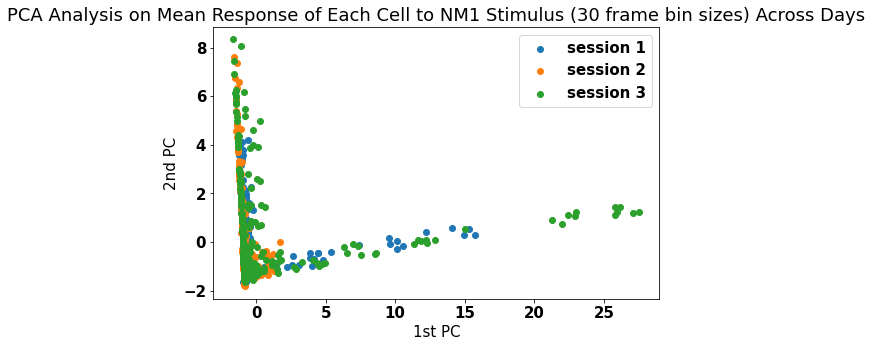

In [223]:
# PCA Model: 2D Visualization
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(transformed_data_pca[transformed_data_pca.Session=="1"][0], transformed_data_pca[transformed_data_pca.Session=="1"][1], label="session 1")
ax.scatter(transformed_data_pca[transformed_data_pca.Session=="2"][0], transformed_data_pca[transformed_data_pca.Session=="2"][1], label="session 2")
ax.scatter(transformed_data_pca[transformed_data_pca.Session=="3"][0], transformed_data_pca[transformed_data_pca.Session=="3"][1], label="session 3")
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.set_title("PCA Analysis on Mean Response of Each Cell to NM1 Stimulus (30 frame bin sizes) Across Days")
plt.legend(loc="upper right")
plt.show()


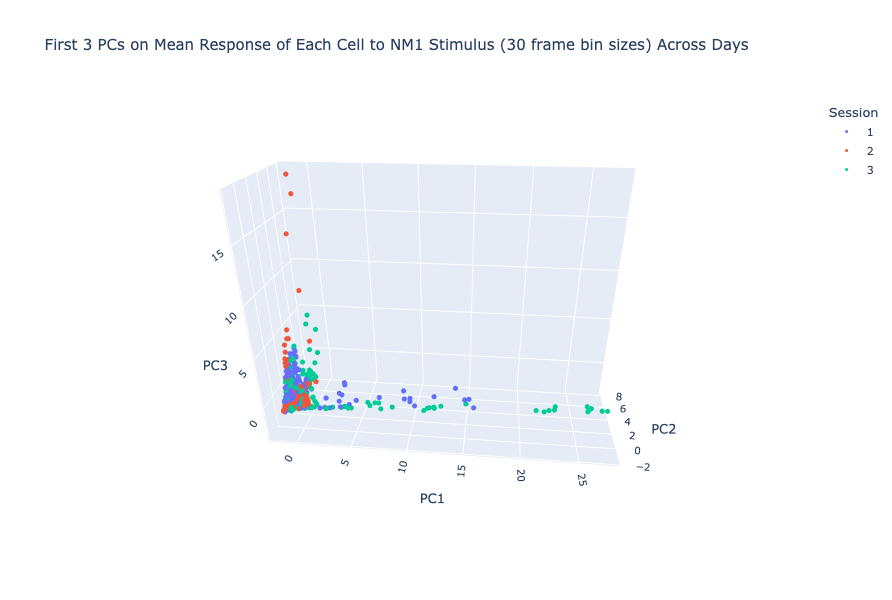

In [222]:
# PCA Model: 3D Visualization
fig = px.scatter_3d(transformed_data_pca, x=0, y=1, z=2, color="Session", labels = {"0": "PC1","1": "PC2", "2": "PC3"}, title = "First 3 PCs on Mean Response of Each Cell to NM1 Stimulus (30 frame bin sizes) Across Days")
fig.update_traces(marker_size=3) # reduce size of scatter points from default size
fig.update_layout(width=800, height=600, font_size=11, scene_aspectmode="data", scene_camera_eye= dict(x=0.2, y=-2.0, z=1)) # adjust plot appearance
fig.show()